In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import math
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
)
from scipy.stats import randint, uniform

### Loading the train set

In [4]:
X_train = pd.read_csv("./Dataset/challenger/train_X.csv")
y_train = pd.read_csv("./Dataset/challenger/train_y.csv")

In [5]:
X_train["Yearly Income - Person"] = X_train["Yearly Income - Person"].str.replace("$","",regex=False).astype(float)
X_train["Total Debt"] = X_train["Total Debt"].str.replace("$","",regex=False).astype(float)
X_train["Credit Limit"] = X_train["Credit Limit"].str.replace("$","",regex=False).astype(float)
X_train["Card on Dark Web"] = X_train["Card on Dark Web"].replace("No", 0)
X_train = X_train.drop(columns=["User","Card","DateTime","Date","User_card"])

C:\Users\wyk28\AppData\Local\Temp\ipykernel_23572\2007215091.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train["Card on Dark Web"] = X_train["Card on Dark Web"].replace("No", 0)


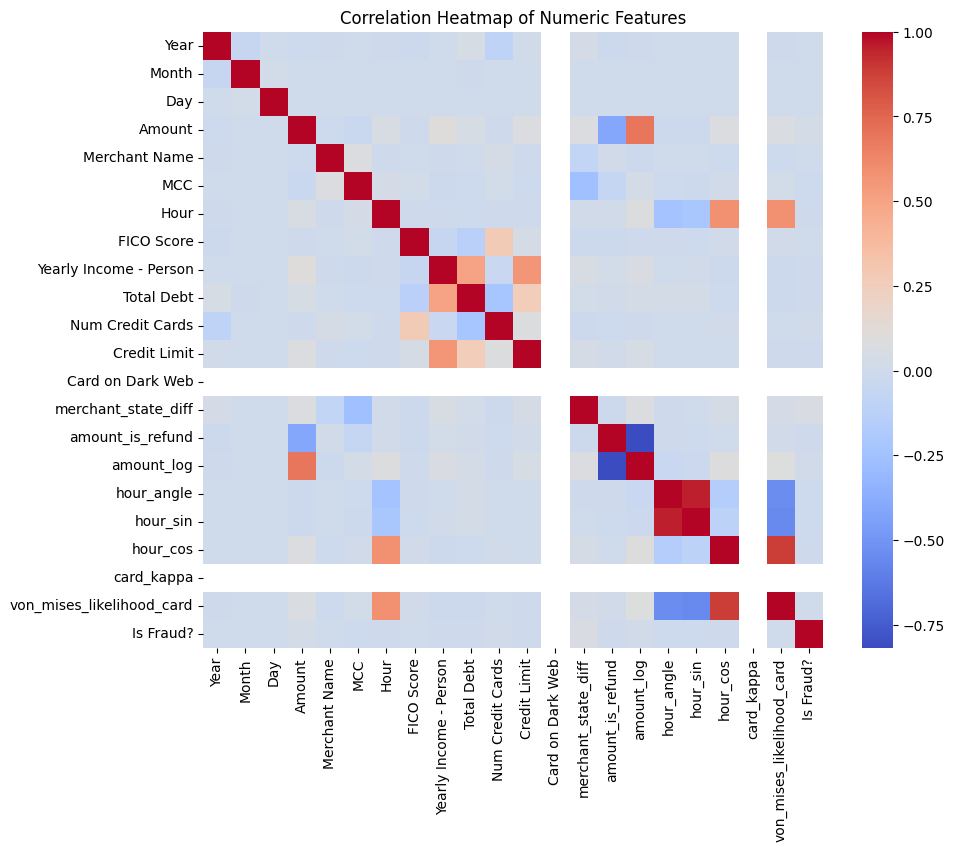

In [37]:
# Visualise the correlation of the numeric features 

df_train = pd.concat([X_train, y_train], axis=1)
corr = df_train.select_dtypes(include=["number", "bool"]).corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

### Hyperparameter tuning

In [ ]:
# To perform encoding of textual features

categorical_cols = ['Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Errors?', 'Zip_str','State','Card Brand']
encoder = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
         categorical_cols)
    ],
    remainder="passthrough"
)

In [ ]:
# Cross-validation pipeline with encoding and sampling applied within each fold

pipeline = ImbPipeline(steps=[
    ("encoder", encoder),
    ("undersample", RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
    ("model", RandomForestClassifier(random_state=42))
])

In [ ]:
# Perform RandomizedSearchCV for hyperparameter tuning of random forest

param_dist = {
    "undersample__sampling_strategy": [0.02, 0.05, 0.1, 0.2],
    "model__n_estimators": [200,250,300,350,400],
    "model__max_depth": list(range(5, 15, 5)),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["sqrt", "log2", 0.5, 0.7],
    "model__class_weight": ["balanced", "balanced_subsample",None]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring={"roc_auc": "roc_auc", "pr_auc": "average_precision"},
    refit="pr_auc",
    cv=3,                         
    verbose=3,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("\nBest parameters found:")
print(search.best_params_)
print(f"Best Validation PR-AUC (from search): {search.best_score_:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\wyk28\Documents\DSA4263 Proj\venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best parameters found:
{'model__class_weight': None, 'model__max_depth': 10, 'model__max_features': 0.7, 'model__min_samples_leaf': 9, 'model__min_samples_split': 15, 'model__n_estimators': 250, 'undersample__sampling_strategy': 0.05}
Best Validation PR-AUC (from search): 0.6527


### Random Forest Classifier

In [36]:
best_para = search.best_params_
best_rf = search.best_estimator_

In [ ]:
# Loading the test dataset

X_test = pd.read_csv("./Dataset/challenger/test_X.csv")
y_test = pd.read_csv("./Dataset/challenger/test_y.csv")

In [25]:
X_test["Yearly Income - Person"] = X_test["Yearly Income - Person"].str.replace("$","",regex=False).astype(float)
X_test["Total Debt"] = X_test["Total Debt"].str.replace("$","",regex=False).astype(float)
X_test["Credit Limit"] = X_test["Credit Limit"].str.replace("$","",regex=False).astype(float)
X_test["Card on Dark Web"] = X_test["Card on Dark Web"].replace("No", 0)
X_test = X_test.drop(columns=["User","Card","DateTime","Date","User_card"])

C:\Users\wyk28\AppData\Local\Temp\ipykernel_23572\257028469.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test["Card on Dark Web"] = X_test["Card on Dark Web"].replace("No", 0)


In [38]:
# Evaluate tuned model on test dataset

y_test_pred_proba = best_rf.predict_proba(X_test)[:, 1]
roc_test = roc_auc_score(y_test, y_test_pred_proba)
pr_test  = average_precision_score(y_test, y_test_pred_proba)

print("\nEvaluation on df_test (final holdout):")
print(f"Test ROC-AUC : {roc_test:.4f}")
print(f"Test PR-AUC  : {pr_test:.4f}")


Evaluation on df_test (final holdout):
Test ROC-AUC : 0.9829
Test PR-AUC  : 0.6642


In [39]:
from sklearn.metrics import precision_recall_curve
import numpy as np

y_scores = y_test_pred_proba

# Get precision, recall and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Avoid division by zero
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)

# thresholds array is 1 element shorter than precision/recall
# So we ignore the last F1 which has no threshold
f1_scores = f1_scores[:-1]

# Find best F1 and corresponding threshold
best_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_idx]

print("=== Best F1-score threshold ===")
print(f"Threshold: {best_threshold_f1:.6f}")
print(f"Precision: {precision[best_idx]:.4f}")
print(f"Recall:    {recall[best_idx]:.4f}")
print(f"F1-score:  {f1_scores[best_idx]:.4f}")



=== Best F1-score threshold ===
Threshold: 0.847788
Precision: 0.7238
Recall:    0.5717
F1-score:  0.6388


In [40]:
y_test_pred = (y_test_pred_proba > best_threshold_f1).astype(int)
print("\nClassification report on test set (threshold="+ str(best_threshold_f1) + "):")
print(classification_report(y_test, y_test_pred, digits=3))


Classification report on test set (threshold=0.8477877442916777):
              precision    recall  f1-score   support

           0      0.999     1.000     1.000   2435782
           1      0.724     0.571     0.639      2902

    accuracy                          0.999   2438684
   macro avg      0.862     0.786     0.819   2438684
weighted avg      0.999     0.999     0.999   2438684

